In [1]:
import pysam
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# PacBio

##### >minimap2 -x map-pb -a -t 6 -o pacbio.sam reference.fasta pacbio_40x.fq.gz

##### >samtools flagstat -@ 6 pacbio.sam > pacbio.stat

51199 + 0 mapped (98.31% : N/A)

In [10]:
samfile = pysam.AlignmentFile("pacbio_sorted.bam", "rb")
genome = next(SeqIO.parse("reference.fasta", "fasta")).seq

========== pacbio_40x.fq.gz  ==========
Number of substitutions:
        A       C       G       T       -
A       0   38461   30826   29043  303520
C   29419       0   35823   26569  365946
G   26566   35984       0   29173  397228
T   29047   30698   37640       0  280733
-  501939  505815  701449  515264       0
mean_read_error=7.09228%


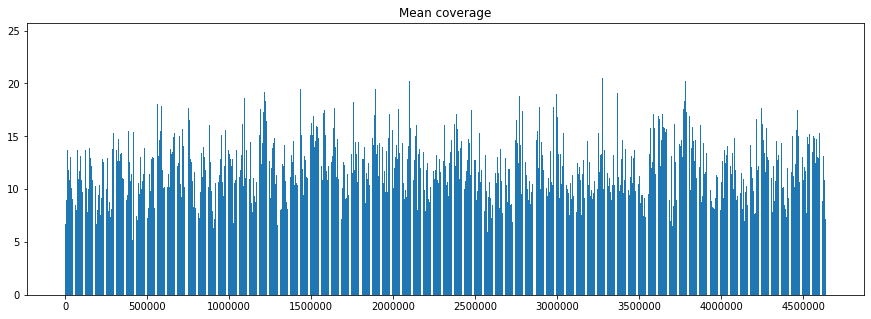

mean_cov=12.01, breadth_cov=0.9461779111683469
Indel stats
2725859 indels of length 1
272869 indels of length 2
47507 indels of length 3
14045 indels of length 4
5897 indels of length 5
2866 indels of length 6
1615 indels of length 7
1016 indels of length 8
650 indels of length 9
424 indels of length 10
303 indels of length 11
227 indels of length 12
191 indels of length 13
143 indels of length 14
86 indels of length 15
61 indels of length 16
35 indels of length 17
48 indels of length 18
27 indels of length 19
26 indels of length 20
22 indels of length 21
18 indels of length 22
17 indels of length 23
14 indels of length 24
22 indels of length 25
10 indels of length 26
13 indels of length 27
17 indels of length 28
6 indels of length 29
6 indels of length 30
9 indels of length 31
2 indels of length 32
6 indels of length 33
7 indels of length 34
5 indels of length 35
5 indels of length 36
3 indels of length 37
2 indels of length 38
3 indels of length 39
7 indels of length 40
2 indels of l

In [11]:
print("========== pacbio_40x.fq.gz  ==========")

# coverage & errors
cov = np.zeros(shape=(len(genome)))
SNP = pd.DataFrame(0, index=['A', 'C', 'G', 'T', '-'], columns=['A', 'C', 'G', 'T', '-'])
quals = pd.DataFrame(0, index=['A', 'C', 'G', 'T', '-'], columns=['A', 'C', 'G', 'T', '-'])

#print(cov)
#print(SNP)

delta = 0
indels = Counter() # length -> count
homopoly = 0

for i, x in enumerate(samfile.pileup('gi|48994873|gb|U00096.2|', fastafile=pysam.FastaFile('reference.fasta'))):
    pos = x.reference_pos
    cov[i] = x.get_num_aligned()
    gen = genome[pos].upper()
    for base in x.get_query_sequences(add_indels=True):
        j = base[0].upper()
        if j != gen and j in "AGCT-":
            SNP.loc[j, gen] += 1
        INS = True
        if len(base) > 1:
            if base[1] == '-':
                INS = False
            num = ""
            for ind in base[2:]:
                if ind in "0123456789":
                    num += ind
                else:
                    break
            num = int(num)
            indels[num] += 1
            
            if gen == genome[pos-1].upper() or gen == genome[pos+1].upper() or \
            len(base[len(base)-num:]) > 1 and base[len(base)-num:][0] == base[len(base)-num:][1]:
                homopoly += num
            for ind in base[len(base)-num:]:
                if INS:
                    SNP.loc['-', ind.upper()] += 1
                else:
                    SNP.loc[ind.upper(), '-'] += 1

print("Number of substitutions:")
print(SNP)
total = sum(cov)
print(f'mean_read_error={round(SNP.iloc[:, :].values.sum()/total*100, 5)}%')


covs = [np.mean(cov[i:i+1000]) for i in range(0, len(cov), 1000)]
plt.figure(figsize=(15, 5))
plt.bar(range(len(covs)), height=covs)
plt.xticks(range(0, len(covs), 500), range(0, len(cov), 500000))
plt.title("Mean coverage")
plt.show()
print(f'mean_cov={round(np.mean(cov), 2)}, breadth_cov={np.count_nonzero(cov)/len(cov)}')

print('Indel stats')
for k, v in sorted(indels.items()):
    print(f'{v} indels of length {k}')
    
print(f'Indels near homopolymers: {round(homopoly/sum(indels.values())*100)}%')

# Oxford Nanopores

##### >minimap2 -x map-ont -a -t 6 -o ONT_2D.sam reference.fasta ONT_2D.fastq.gz

##### >samtools flagstat -@ 6 ONT_2D.sam > ONT_2D.stat

29565 + 0 mapped (92.09% : N/A)

In [17]:
genome = next(SeqIO.parse("reference.fasta", "fasta")).seq


========== ONT_2D.fastq.gz  ==========
Number of substitutions:
        A       C       G       T       -
A       0    6938   29590    5831  648838
C    5808       0    4271   46647  561305
G   46844    4346       0    5623  560507
T    5727   29410    6996       0  610449
-  222728  196798  201256  222869       0
mean_read_error=3.49387%


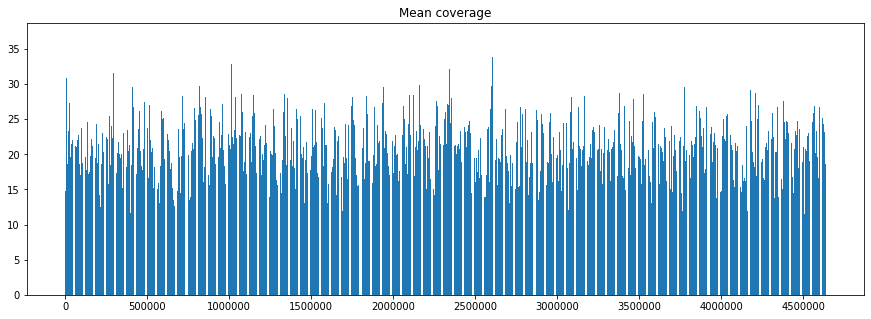

mean_cov=21.11, breadth_cov=0.9968482706224036
Indel stats
1194620 indels of length 1
381204 indels of length 2
155145 indels of length 3
44194 indels of length 4
18108 indels of length 5
9882 indels of length 6
4259 indels of length 7
2256 indels of length 8
1654 indels of length 9
866 indels of length 10
492 indels of length 11
458 indels of length 12
206 indels of length 13
126 indels of length 14
118 indels of length 15
75 indels of length 16
33 indels of length 17
38 indels of length 18
17 indels of length 19
10 indels of length 20
11 indels of length 21
7 indels of length 22
3 indels of length 23
4 indels of length 24
7 indels of length 25
4 indels of length 26
1 indels of length 27
1 indels of length 28
1 indels of length 30
3 indels of length 32
2 indels of length 33
1 indels of length 34
3 indels of length 36
1 indels of length 37
1 indels of length 43
2 indels of length 45
1 indels of length 49
1 indels of length 52
1 indels of length 54
1 indels of length 72
5 indels of leng

In [24]:
print("========== ONT_2D.fastq.gz  ==========")


# coverage & errors
cov = np.zeros(shape=(len(genome)))
SNP = pd.DataFrame(0, index=['A', 'C', 'G', 'T', '-'], columns=['A', 'C', 'G', 'T', '-'])


delta = 0
indels = Counter() # length -> count
homopoly = 0

for i, line in enumerate(open("ONT.pileup")):
    _, pos, gen, num_aligned, seqs, quals = line.strip().split("\t")
    cov[int(pos)-1] = int(num_aligned)
    if int(num_aligned) > 0:
        q = 0
        while q < len(seqs):
            if seqs[q] == '^':
                q += 2
            elif seqs[q] == '$':
                q += 1
            elif seqs[q] == '*':
                SNP.loc['-', gen] += 1
                q += 1
            elif seqs[q] == '.' or seqs[q] == ',':
                q += 1
            elif seqs[q].upper() in "AGTC":
                SNP.loc[seqs[q].upper(), gen] += 1
                q += 1
            elif seqs[q] in "+-":
                INS = True
                if seqs[q] == '-':
                    INS = False
                num = ""
                q += 1
                while seqs[q] in "0123456789":
                    num += seqs[q]
                    q += 1
                num = int(num)
                indels[num] += 1
                
                if gen == genome[int(pos)-2].upper() or gen == genome[int(pos)].upper() or \
                    num > 1 and seqs[q].upper() == seqs[q+1].upper():
                    homopoly += num
            
                
                for j in range(num):
                    val = seqs[q+j].upper()
                    if INS:
                        SNP.loc['-', val] += 1
                    else:
                        SNP.loc[val, '-'] += 1
                q += num
                

print("Number of substitutions:")
print(SNP)
total = sum(cov)
print(f'mean_read_error={round(SNP.iloc[:, :].values.sum()/total*100, 5)}%')


covs = [np.mean(cov[i:i+1000]) for i in range(0, len(cov), 1000)]
plt.figure(figsize=(15, 5))
plt.bar(range(len(covs)), height=covs)
plt.xticks(range(0, len(covs), 500), range(0, len(cov), 500000))
plt.title("Mean coverage")
plt.show()
print(f'mean_cov={round(np.mean(cov), 2)}, breadth_cov={np.count_nonzero(cov)/len(cov)}')

print('Indel stats')
for k, v in sorted(indels.items()):
    print(f'{v} indels of length {k}')
    
print(f'Indels near homopolymers: {round(homopoly/sum(indels.values())*100)}%')

У Oxford Nanopore более длинные инделы, и они гораздо чаще встречаются рядом с гомополимерными участками. У PacBio чаще встречаются mismatches, чем у ONT. Глубина покрытия у ONT больше, чем у PacBio. Процент ошибок на порядок выше, чем в ридах Illumina из дз2